# AI 4 StoryLines - Bayesian LR

In this example, we are going to showcase how we can do sensitivity analysis using a simple linear regression model.

In [1]:
import autoroot
import numpyro
import numpy as np
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from pathlib import Path
from dataclasses import dataclass
import xarray as xr
import pandas as pd
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from bayesevt._src.utils.io import get_list_filenames
from utils import plot_contour, plot_imshow, plot_pcolormesh, interpolate_rectilinear_grid
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

We can see that there is some explained variance that is missing.
Potentially we can explain this with the regression model.

## Load Data

We have a clean analysis-ready dataset available from the previous notebook.
We will save it and revisit it later.

First, we will make sure that the models in the covariates and the QoI are the same.

In [2]:
save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/analysis/"

In [3]:
# load covariates
df = pd.read_csv(Path(save_dir).joinpath("covariates.csv"), index_col=0)
# load qoi
ds = xr.open_dataset(Path(save_dir).joinpath("qoi.nc"))
# quick check
assert df.model.values.sort() == ds.model.values.sort()

ds

<xarray.Dataset> Size: 48kB
Dimensions:    (lon: 21, lat: 19, model: 28)
Coordinates:
  * lon        (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
  * lat        (lat) float64 152B 26.25 28.75 31.25 33.75 ... 66.25 68.75 71.25
  * model      (model) <U16 2kB 'access_cm2' 'access_esm1_5' ... 'ukesm1_0_ll'
    land_mask  (lat, lon) int16 798B ...
Data variables:
    tasmax     (model, lat, lon) float32 45kB ...
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

## Baseline Model - Linear Regression

#### Input Data

In [4]:
covariate_names = ["sst", "sm_sur", "t2m", "z500_zonal"]
qoi_names = ["tasmax"]
x = df.sort_values(by=["model"])[covariate_names].values
u = ds.sortby("model").stack(spatial=["lat", "lon"]).tasmax.values

In [5]:
x.shape, u.shape

((28, 4), (28, 399))

#### Model

In [21]:
from models import LinearRegression

num_spatial = u.shape[1]
model = LinearRegression(num_spatial=num_spatial)

In [22]:
def mle_guide(x, y):
    pass


In [23]:
from numpyro.infer import Predictive, SVI, Trace_ELBO
rng_key = jrandom.PRNGKey(123)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model.model, mle_guide, optimizer, loss=Trace_ELBO())


In [24]:
num_steps = 10_000
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

svi_result = svi.run(rng_key=rng_key_train, num_steps=num_steps, x=x, y=u)

100%|█| 10000/10000 [00:02<00:00, 4190.35it/s, init loss: 89486.2578, avg. loss 


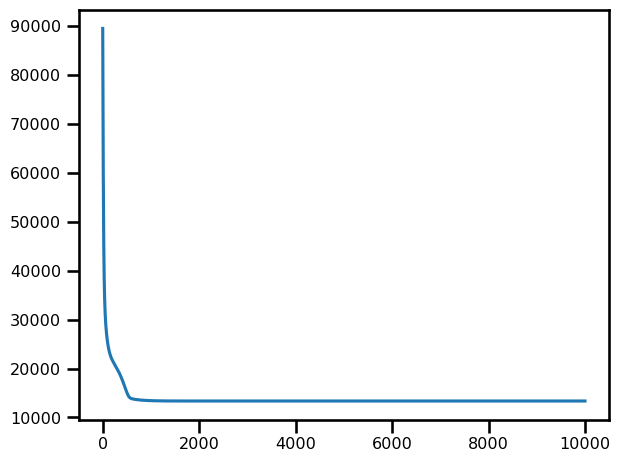

In [25]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
plt.tight_layout()
plt.show()

In [26]:
params = svi_result.params
# samples = guide.get_posterior(params)
predictive = Predictive(model=model.model, params=params, num_samples=1)
posterior_samples = predictive(jrandom.PRNGKey(0), x=x)

In [27]:
posterior_samples["obs"].shape

(1, 28, 399)

In [28]:
loc = svi_result.params["loc"]
bias = svi_result.params["bias"]
scale = svi_result.params["scale"]
loc.shape, scale

((399, 4), Array(0.8000022, dtype=float32))

### Post-Model Analysis

We can extract the parameters for the regression model.
The coefficient corresponds to the slope of the regression model.

We want to plot the coefficient for each of the variables.
First, we need to reshape the 1D Vector to be a `lat-lon` vector.

Now, we will add each of these to our dataset so that we can see our

In [29]:
# sea surface height
ds = ds.stack(spatial=["lat", "lon"])
ds["weights"] = (("spatial", "covariate"), loc)
ds["bias"] = (("spatial",), bias)
ds["pred"] = (("model", "spatial",), posterior_samples["obs"][0])
ds = ds.assign_coords({"covariate": ["sst", "sm", "t2m", "z500"],})
ds = ds.unstack()

## Analysis Dataset

In [30]:
vmin = -2.0
vmax = 2.0

In [31]:
from utils import plot_imshow, plot_imshow_smooth

In [32]:
ds

<xarray.Dataset> Size: 104kB
Dimensions:    (lat: 19, lon: 21, model: 28, covariate: 4)
Coordinates:
  * lat        (lat) float64 152B 26.25 28.75 31.25 33.75 ... 66.25 68.75 71.25
  * lon        (lon) float64 168B -20.0 -17.5 -15.0 -12.5 ... 25.0 27.5 30.0
  * model      (model) <U16 2kB 'access_cm2' 'access_esm1_5' ... 'ukesm1_0_ll'
    land_mask  (lat, lon) int16 798B 0 0 0 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
  * covariate  (covariate) <U4 64B 'sst' 'sm' 't2m' 'z500'
Data variables:
    tasmax     (model, lat, lon) float32 45kB 3.244 2.818 2.714 ... 8.945 8.988
    weights    (covariate, lat, lon) float32 6kB 0.4097 0.3724 ... -0.05909
    bias       (lat, lon) float32 2kB -0.1314 -0.1514 ... -0.5202 -0.4669
    pred       (model, lat, lon) float32 45kB 2.182 3.161 3.173 ... 7.959 8.386
    score      (lat, lon) float64 3kB -0.2678 -0.6191 -0.3717 ... 0.5554 0.5537
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    source:                 ACCESS-CM2 (2019): \naerosol: UKCA-GLOMAP-mode\na...
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variant_label:          r1i1p1f1
    version:                v20191108
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/9ecf99bf-2241-4c6a-acea-15d12be52c43
    license:                CMIP6 model data produced by CSIRO is licensed un...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

### R2 Score

In [33]:
from sklearn.metrics import r2_score

In [34]:
ds = ds.stack(spatial=["lat", "lon"])
score = r2_score(y_true=ds.tasmax.values, y_pred=ds.pred.values, multioutput="raw_values")
ds["score"] = (("spatial"), score)
ds = ds.unstack()

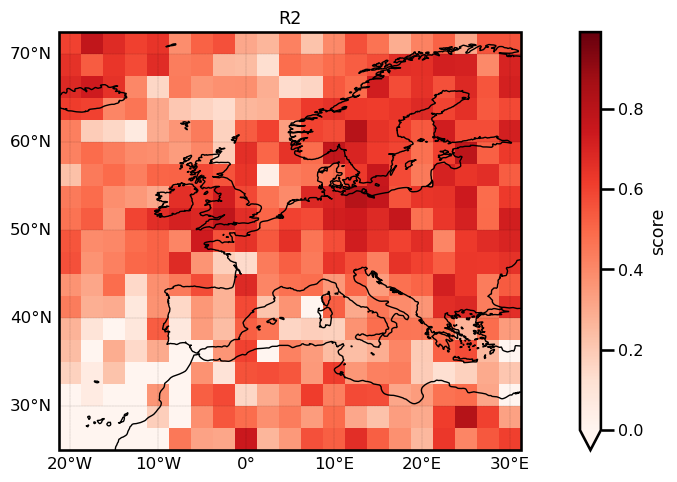

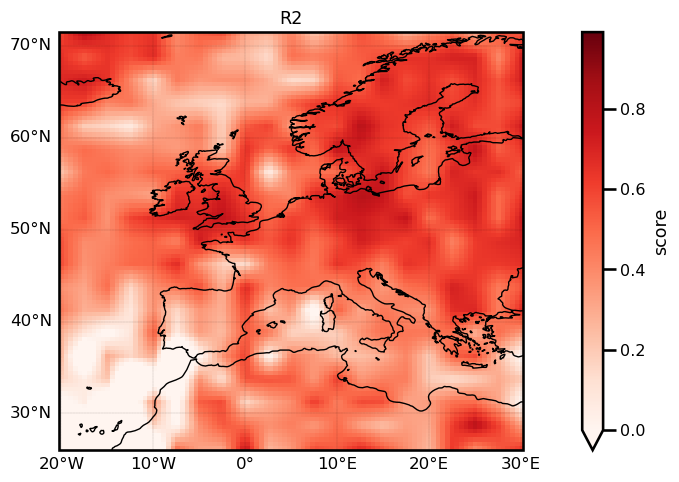

In [35]:
score = ds.score

plot_pcolormesh(
    score, 
    "R2", vmin=0.0, vmax=0.99, cmap="Reds",
);

# interpolate
score = score.interp(
        lon=np.linspace(score.lon.values.min(), score.lon.values.max(), 100),
        lat=np.linspace(score.lat.values.min(), score.lat.values.max(), 100),
        method="linear"
        
    )

plot_imshow(
    score,
    "R2", vmin=0.0, vmax=0.99, cmap="Reds", num_levels=None
);

### Plot Bias

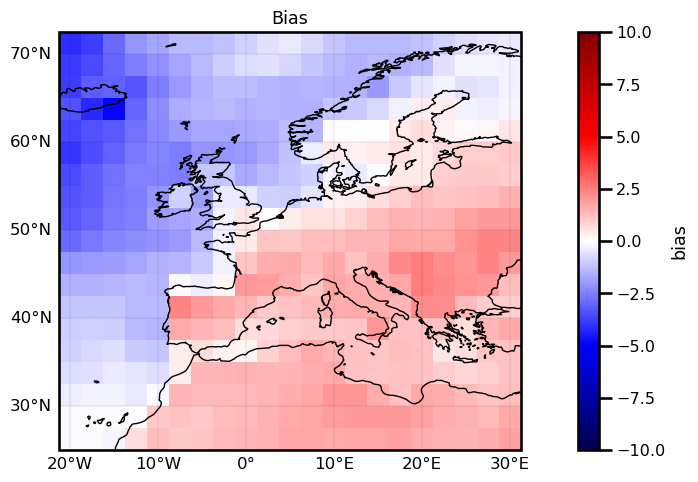

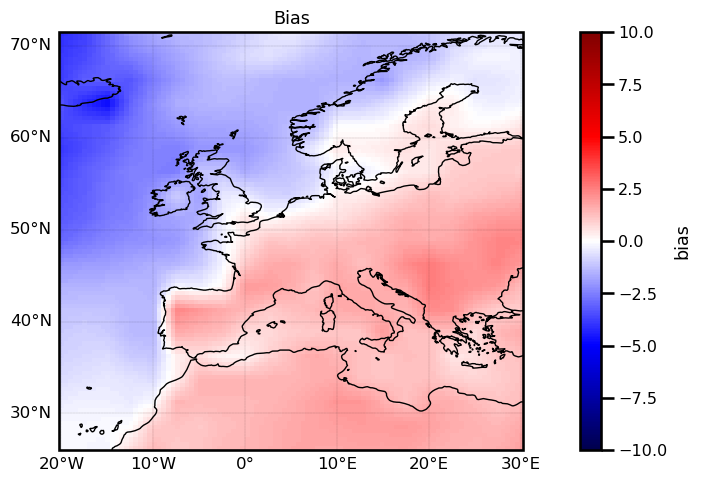

In [36]:
# plot weights
bias = ds.bias
plot_pcolormesh(
    bias,
    variable="Bias", 
    vmin=-10.0, vmax=10.0, cmap="seismic"
);

# interpolate
bias = bias.interp(
    lon=np.linspace(bias.lon.values.min(), bias.lon.values.max(), 100),
    lat=np.linspace(bias.lat.values.min(), bias.lat.values.max(), 100),
    method="linear"
    
)

plot_imshow(
    bias, 
    "Bias", vmin=-10.0, vmax=10.0, cmap="seismic", num_levels=None
);

In [37]:
def plot_maps(covariate, variable_name):
    
    # plot weights
    ds_subset = ds.weights.sel(covariate=covariate)
    plot_pcolormesh(
        ds_subset,
        variable=variable_name, 
        vmin=-2.0, vmax=2.0, cmap="seismic"
    );
    
    # interpolate
    ds_subset = ds_subset.interp(
        lon=np.linspace(ds_subset.lon.values.min(), ds_subset.lon.values.max(), 100),
        lat=np.linspace(ds_subset.lat.values.min(), ds_subset.lat.values.max(), 100),
        method="linear"
        
    )
    
    plot_imshow(
        ds_subset, 
        variable_name, vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=None
    );

### Sea Surface Temperature

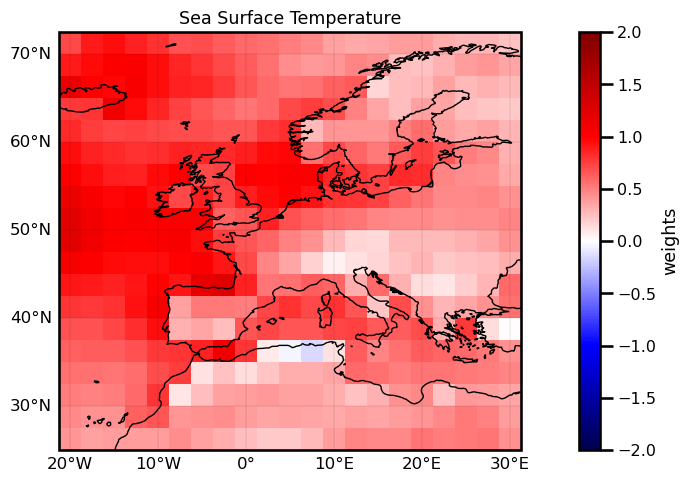

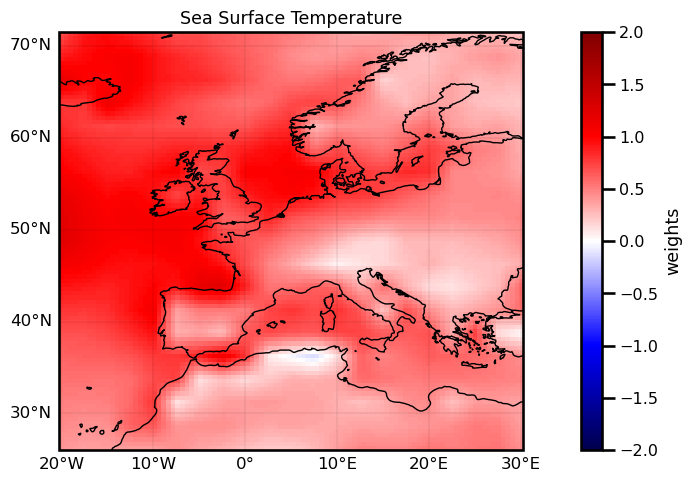

In [42]:
variable_name = "Sea Surface Temperature"
covariate = "sst"
plot_maps(covariate, variable_name)

### Soil Moisture

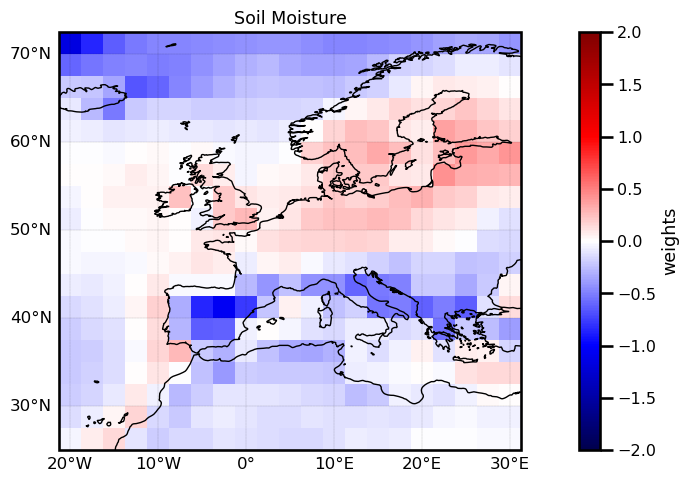

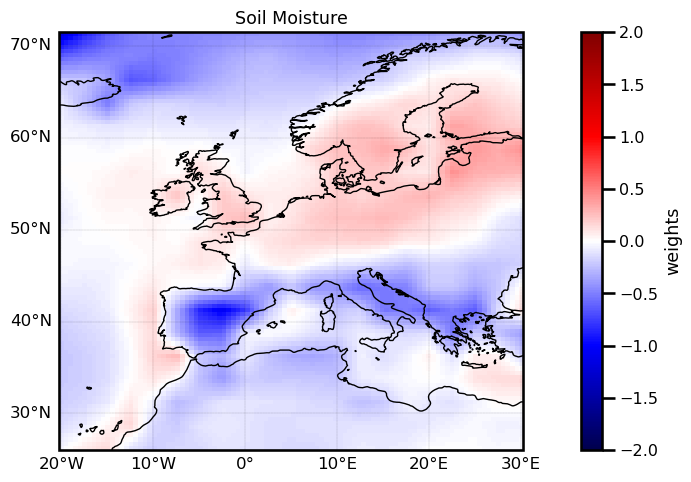

In [39]:
variable_name = "Soil Moisture"
covariate = "sm"

plot_maps(covariate, variable_name)

### 2m Temperature

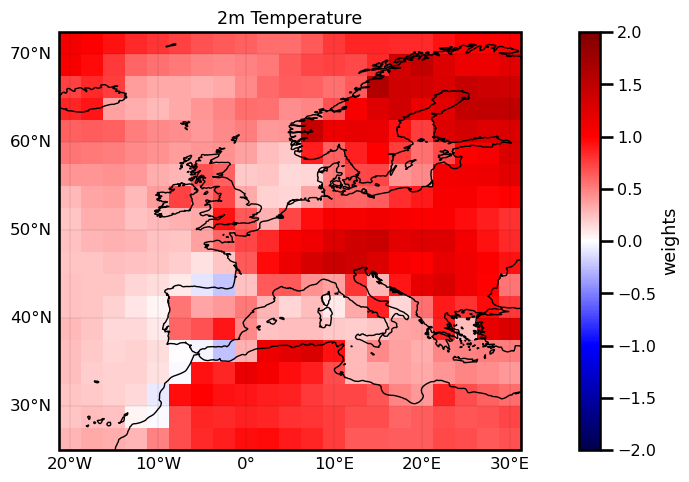

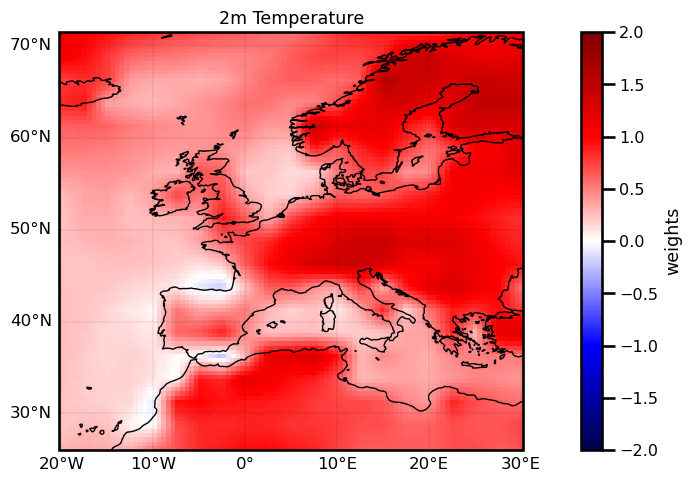

In [40]:
variable_name = "2m Temperature"
covariate = "t2m"

plot_maps(covariate, variable_name)

### Geopotential

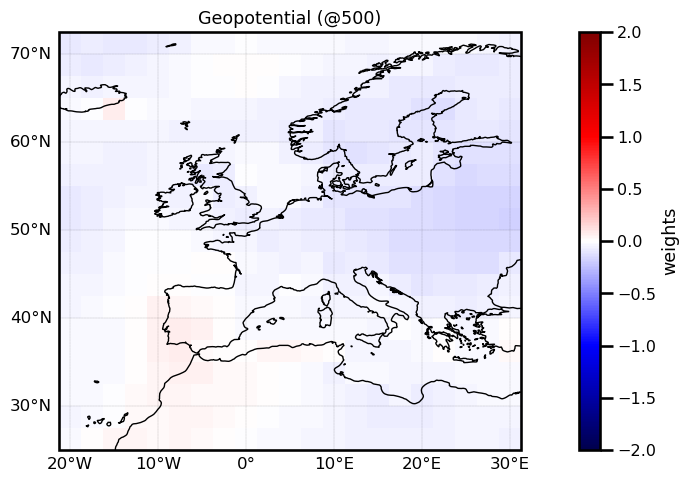

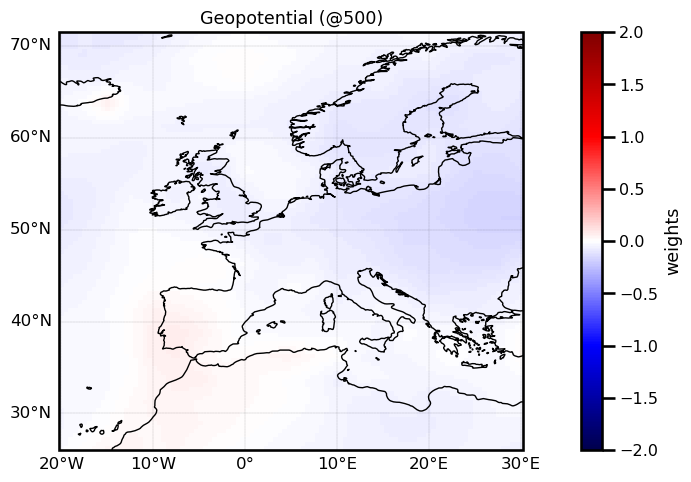

In [41]:
variable_name = "Geopotential (@500)"
covariate = "z500"

plot_maps(covariate, variable_name)

## Things to Do


* Standardize Input/Output Data (see [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing))
* Find the Best Parameters with Cross Validation
* Choose a Better Linear Model ([LASSO](https://scikit-learn.org/stable/modules/linear_model.html#lasso), [LARS](https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression), [Elastic-Net](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net), [Generalized Linear Model](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models), [Quantile Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor))